Cette semaine, après avoir travaillé sur [l'âge moyen des députés français](http://flothesof.github.io/age-moyen-deputes-francais.html), je vous propose de nous intéresser à celui des sénateurs.

Premier constat : la tâche ne va pas être aussi facile que dans le cas des députés. En effet, je n'ai pas réussi à trouver une base de données avec les dates de naissance des sénateurs ou de fichier PDF comme dans le cas des députés avec toutes les données d'un coup. Il va donc falloir travailler un peu plus afin d'extraire les données du [site web du sénat et son index alphabétique](http://www.senat.fr/senateurs/senatl.html). 

Afin de faire ceci, nous allons utiliser les outils Python classique pour ce genre de tâche : `requests` et `beautiful soup`.

# Comment extraire la date de naissance d'un sénateur de sa notice bibliographique ?

Tout part de la notice bibliographique du sénateur. Par exemple, celle de [Michel Berson, sénateur de l'Essonne](http://www.senat.fr/senateur/berson_michel11068s.html).

On peut télécherger le contenu de cette page à l'aide du code suivant :

In [1]:
import requests

In [60]:
r = requests.get("http://www.senat.fr/senateur/berson_michel11068s.html")
r

<Response [200]>

La réponse 200 signifie que le téléchargement de la page s'est bien passé. 

Pour extraire la date de naissance, il faut regarder le code HTML de la page et utiliser `beautiful soup`. On construit notre soupe :

In [61]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.text, 'html.parser')

La date de naissance se trouve dans un tag 'dd' lui-même contenu dans un tag 'dl'. On peut trouver ces éléments ainsi :

In [62]:
items = soup.find('dl').find_all('dd')
items

[<dd>
 <a class="link-color-01" href="mailto:m.berson@senat.fr">m.berson@senat.fr</a> 
 </dd>, <dd>
 <ul class="list-contact-01">
 <li><a href="http://www.michelberson.fr" target="_blank"><img alt="http://www.michelberson.fr" src="/fileadmin/templates/images/data/picto_contact_blog.png"/></a></li>
 <li><a href="http://www.facebook.com/michel.berson" target="_blank"><img alt="Profil Facebook" src="/fileadmin/templates/images/data/picto_contact_facebook.png"/></a></li>
 </ul>
 <ul class="list-contact-01">
 <li><a href="http://twitter.com/michel_berson" target="_blank"><img alt="Compte Twitter" src="/fileadmin/templates/images/data/picto_contact_twitter.png"/></a></li>
 </ul>
 </dd>, <dd>Né le 21 avril 1945</dd>, <dd>Cadre dans le secteur bancaire</dd>, <dd><img alt="Place dans l'hémicycle" src="/fileadmin/templates/images/senateurs/hemicycle/place-hemicycle_311.jpg" width="170">
 </img></dd>, <dd><a href="/senateurs/sencir.html#c265"><img alt="Circonscription" src="/fileadmin/templates/i

La date de naissance qui nous intéresse est dans le deuxième item :

In [84]:
[item.text for item in items if item.text.startswith('Né')]

['Né le 21 avril 1945']

On peut, sur le même principe, également écrire une fonction qui extrait le nom du sénateur de la page :

In [85]:
soup.find('h1','title-01').text

'Liste des Sénateurs par ordre alphabétique'

Maintenant que nous savons faire ça, nous pouvons écrire un fonction qui extrait la date de naissance de l'url de la page d'un sénateur, de même que son nom :

In [86]:
def url2data(url):
    """Télécharge la page de l'url et extrait la date de naissance du sénateur."""
    r = requests.get(url)
    if r.ok:
        soup = BeautifulSoup(r.text, 'html.parser')
        birthdate = [item.text for item in soup.find('dl').find_all('dd') if item.text.startswith('Né')][0]
        name = soup.find('h1','title-01').text
        return (name, birthdate)
    else:
        raise("Something went wrong with the web request")

On peut tester la fonction :

In [87]:
url2data("http://www.senat.fr/senateur/berson_michel11068s.html")

('M. Michel Berson', 'Né le 21 avril 1945')

Pour avoir toutes les dates de naissances, il nous faut maintenant appliquer cette procédure à toutes les urls que l'on trouve sur l'index alphabétique du sénat.

# Répéter l'opération d'extraction pour chaque sénateur

A partir de la page d'index biographique, nous pouvons, de la même manière que précédemment, extraire les liens vers les différentes pages de sénateurs :

In [88]:
r = requests.get("http://www.senat.fr/senateurs/senatl.html")
r

<Response [200]>

On fait une petite sousoupe :

In [89]:
soup = bs4.BeautifulSoup(r.text, 'html.parser')

Et maintenant on cherche des liens qui sont dans des balises du type ul li a. Tant qu'à faire, on ne garde que ceux qui pointen vers une page de sénateur :

In [95]:
urls = [link.get('href') for link in soup.select('ul li a') if link.get('href').startswith('/senateur/')]

In [96]:
len(urls)

348

Nous dénombrons bien 348 sénateurs. Passons à l'extraction des dates de naissance.

In [97]:
birthdates = {}
for url in urls:
    name, bd = url2data("http://www.senat.fr" + url)
    birthdates[name] = bd

Regardons le résultat :

In [98]:
birthdates

{'M. Abdourahamane Soilihi': 'Né le 4 octobre 1959',
 'M. Alain Anziani': 'Né le 30 mai 1951',
 'M. Alain Bertrand': 'Né le 23 février 1951',
 'M. Alain Chatillon': 'Né le 15 mars 1943',
 'M. Alain Dufaut': 'Né le 2 janvier 1944',
 'M. Alain Duran': 'Né le 2 janvier 1958',
 'M. Alain Fouché': 'Né le 4 décembre 1942',
 'M. Alain Gournac': 'Né le 13 septembre 1943',
 'M. Alain Houpert': 'Né le 13 août 1957',
 'M. Alain Joyandet': 'Né le 15 janvier 1954',
 'M. Alain Marc': 'Né le 29 janvier 1957',
 'M. Alain Milon': 'Né le 16 septembre 1947',
 'M. Alain Néri': 'Né le 1er mai 1942',
 'M. Alain Richard': 'Né le 29 août 1945',
 'M. Alain Vasselle': 'Né le 27 juin 1947',
 'M. Albéric de Montgolfier': 'Né le 6 juillet 1964',
 'M. Alex Türk': 'Né le 25 janvier 1950',
 'M. André Gattolin': 'Né le 24 juin 1960',
 'M. André Reichardt': 'Né le 5 décembre 1949',
 'M. André Trillard': 'Né le 24 octobre 1947',
 'M. Antoine Karam': 'Né le 21 février 1950',
 'M. Antoine Lefèvre': 'Né le 18 février 1966'

On peut facilement construire une dataframe pandas avec ces données :

In [99]:
import pandas as pd

In [112]:
df = pd.DataFrame(data=[(key, birthdates[key]) for key in birthdates], 
             columns=('Nom', 'Date de naissance'))
df.head()

,Nom,Date de naissance
0,M. Michel Mercier,Né le 7 mars 1947
1,Mme Caroline Cayeux,Née le 1er novembre 1948
2,M. David Assouline,Né le 16 juin 1959
3,Mme Lana Tetuanui,Née le 23 février 1970
4,M. Pierre Charon,Né le 1er mars 1951


On peut, comme dans mon billet précédent, calculer des dates de naissance numériques à l'aide de ces données :

In [109]:
def convert2date(date_str):
    d = {'janvier': 1, 'février': 2, 'mars': 3, 'avril': 4,
         'mai': 5, 'juin': 6, 'juillet': 7, 'août': 8, 
         'septembre': 9, 'octobre': 10, 'novembre': 11, 'décembre':12}
    splits = date_str.split(' ')[2:]
    
    if splits[0].startswith('1er'):
        splits.pop(0)
        splits.insert(0, '1')
    
    return pd.Timestamp(splits[2] + '/' + str(d[splits[1]]) + '/' + splits[0])

In [115]:
df['Date de naissance2'] = df['Date de naissance'].map(convert2date)

In [116]:
df.head()

,Nom,Date de naissance,Date de naissance2
0,M. Michel Mercier,Né le 7 mars 1947,1947-03-07
1,Mme Caroline Cayeux,Née le 1er novembre 1948,1948-11-01
2,M. David Assouline,Né le 16 juin 1959,1959-06-16
3,Mme Lana Tetuanui,Née le 23 février 1970,1970-02-23
4,M. Pierre Charon,Né le 1er mars 1951,1951-03-01


Enfin, on peut calculer l'âge de chaque sénateur :

In [114]:
import datetime

In [120]:
df['Âge'] = pd.Timestamp(datetime.date.today()) - df['Date de naissance2']
df['Âge (années)'] = [x.days / 365.25 for x in df['Âge']]

In [121]:
df.head()

,Nom,Date de naissance,Date de naissance2,Âge,Âge (années)
0,M. Michel Mercier,Né le 7 mars 1947,1947-03-07,25147 days,68.848734
1,Mme Caroline Cayeux,Née le 1er novembre 1948,1948-11-01,24542 days,67.192334
2,M. David Assouline,Né le 16 juin 1959,1959-06-16,20663 days,56.572211
3,Mme Lana Tetuanui,Née le 23 février 1970,1970-02-23,16758 days,45.880903
4,M. Pierre Charon,Né le 1er mars 1951,1951-03-01,23692 days,64.865161


# Analyse des données recueillies 

On peut maintenant tracer de jolis histogrammes :

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

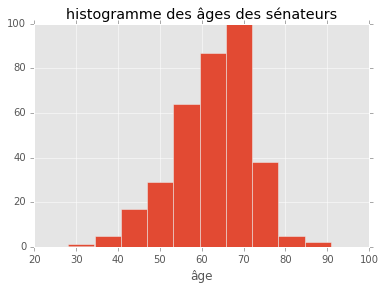

In [127]:
df['Âge (années)'].hist()
plt.xlabel('âge')
plt.title('histogramme des âges des sénateurs')

On peut demander à pandas de nous calculer les données statistiques usuelles pour ces âges :

Afin de comparer ces âges à la population française, nous réutilisons le code de mon post précédent :

In [129]:
df_pop = pd.read_excel('http://www.insee.fr/fr/ppp/bases-de-donnees/donnees-detaillees/bilan-demo/fichiers-xls/pop-1janvier-fm.xls',
                      skiprows=7,
                      header=1,
                      skipfooter=3)

In [130]:
decimation_factor = 1000
french_pop_ages = []
for ind, value in enumerate(df_pop['Ensemble']):
    french_pop_ages += [ind for _ in range(int(value / decimation_factor))]

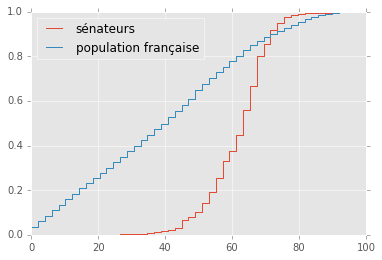

In [134]:
import numpy as np
import statsmodels.api as sm # recommended import according to the docs

age_grid = np.linspace(0, 100)
ecdf_mp = sm.distributions.ECDF(df['Âge (années)'].values)
ecdf_french_pop = sm.distributions.ECDF(french_pop_ages)
y_mp = ecdf_mp(age_grid)
y_french_pop = ecdf_french_pop(age_grid)
plt.step(age_grid, y_mp, label='sénateurs')
plt.step(age_grid, y_french_pop, label='population française')
plt.legend(loc='upper left')

Finalement, on peut passer à la comparaison des statistiques par quartiles :

In [128]:
df['Âge (années)'].describe()

count    348.000000
mean      62.775787
std        9.039639
min       28.109514
25%       57.123203
50%       63.930185
75%       68.780972
max       90.852841
Name: Âge (années), dtype: float64

In [135]:
pd.Series(french_pop_ages).describe()

count    64152.000000
mean        40.538175
std         24.030176
min          0.000000
25%         20.000000
50%         41.000000
75%         59.000000
max        105.000000
dtype: float64

Finalement, on peut produire le tableau récapitulatif suivant :

| population             | âge médian | âge minimal | âge maximal | 25% de la population a moins de | 50% a moins de | 50% a plus de | 25% a plus de |
|------------------------|------------|-------------|-------------|---------------------------------|----------------|---------------|---------------|
| les Français           | 41 ans     | 0 ans       | 105 ans     | 20 ans                          | 41 ans         | 41 ans        | 59 ans        |
| les sénateurs français | 64 ans     | 28 ans      | 91 ans      | 57 ans                          | 64 ans         | 64 ans        | 69 ans        |

# Conclusions 

Cette nouvelle analyse consolide l'idée selon laquelle les français sont représentés par des élus dans une tranche d'âge bien éloignée d'une répartition comparable à la population française.

Evidemment, il est difficile de tirer des conclusions générales à partir de ce chiffre, mais il est frappant à quel point les sénateurs sont vieux par rapport disons, l'âge de la retraite. D'une certaine manière, la moitié des sénateurs ont plus que l'âge de la retraite.